In [8]:
!pip install lime -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# 0. Overview
This section explores the implementation, evaluation, and interpretation of two contrasting text classification approaches for the BBC dataset: a white box keyword-based classifier and a black box RoBERTa model. These models represent different points on the interpretability-performance spectrum in machine learning.

The white box keyword-based classifier uses TF-IDF vectorization to identify the most distinctive words for each category. This transparent approach relies on simple keyword matching, where documents are classified based on the frequency of category-specific keywords. While potentially less powerful than complex neural models, this method offers complete transparency in how classifications are made, with each prediction traceable to specific keyword occurrences.

In contrast, RoBERTa represents a black box approach - a transformer-based language model that leverages contextual embeddings and attention mechanisms to capture complex linguistic patterns. RoBERTa likely offers superior performance but at the cost of interpretability (and performance), as its internal decision-making process involves millions of parameters interacting in ways that aren't easily understood by humans.

This juxtaposition allows us to explore the fundamental trade-off between model interpretability and performance, a critical consideration in trustworthy AI applications. By evaluating both approaches, we can assess whether the performance gains of the black box model justify the sacrifice in interpretability for this particular text classification task.

THIS NOTEBOOK RAN IN A GOOGLE COLAB WITH A T4 GPU

In [15]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score
)
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_scheduler
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from lime.lime_text import LimeTextExplainer
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from torch.optim import AdamW
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import random
import pickle
import torch
import shap
import os
plt.style.use("dark_background")

In [21]:
bbc_df = pd.read_csv("bbc_dataset_preprocessed.csv")
bbc_df.head()

,file_name,category,text,cleaned_text,normalized_text
0,001.txt,business,Ad sales boost Time Warner profit\n\nQuarterly...,ad sales boost time warner profit quarterly pr...,ad sale boost time warner profit quarterly pro...
1,002.txt,business,Dollar gains on Greenspan speech\n\nThe dollar...,dollar gains on greenspan speech the dollar ha...,dollar gain greenspan speech dollar hit highes...
2,003.txt,business,Yukos unit buyer faces loan claim\n\nThe owner...,yukos unit buyer faces loan claim the owners o...,yukos unit buyer face loan claim owner embattl...
3,004.txt,business,High fuel prices hit BA's profits\n\nBritish A...,high fuel prices hit ba s profits british airw...,high fuel price hit ba profit british airway b...
4,005.txt,business,Pernod takeover talk lifts Domecq\n\nShares in...,pernod takeover talk lifts domecq shares in uk...,pernod takeover talk lift domecq share uk drin...


In [22]:
# split the data
X = bbc_df['normalized_text']
y = bbc_df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
feature_names = tfidf_vectorizer.get_feature_names_out()

# 1. Model Learning

## 1.1 White Box Model Learning (keyword-based classifier)

## Methodology

Our keyword-based classifier operates on a simple yet effective principle: documents are classified based on the presence and frequency of category-specific keywords. The approach consists of two main phases:

1. **Keyword Extraction:** Using TF-IDF vectorization, we identify the most distinctive terms for each category in the training data. By summing TF-IDF scores across all documents within a category, we extract the top 20 keywords that best characterize each class.

2. **Classification Mechanism:** For each document in the test set, we count the occurrences of category-specific keywords and assign the document to the category with the highest cumulative keyword count.

This approach mirrors certain aspects of Naive Bayes classification but focuses exclusively on the most informative words rather than the entire vocabulary, improving interpretability while maintaining reasonable performance.

In [23]:
def extract_top_keywords(vectorizer, X_train, y_train, n_keywords=15):
    feature_names = vectorizer.get_feature_names_out()
    keywords_dict = {}

    # group documents by category
    for category in np.unique(y_train):
        # get indices of documents in this category
        category_indices = np.where(y_train == category)[0]

        if len(category_indices) > 0:
            # sum TF-IDF values for each word across all documents in this category
            category_tfidf = X_train[category_indices].sum(axis=0)

            # convert to array and sort by decreasing importance
            category_tfidf = np.asarray(category_tfidf).flatten()
            top_indices = category_tfidf.argsort()[-n_keywords:][::-1]

            # get the corresponding words
            top_words = [feature_names[i] for i in top_indices]
            keywords_dict[category] = top_words

    return keywords_dict

# extract top keywords for each category
keyword_dict = extract_top_keywords(tfidf_vectorizer, X_train_tfidf, y_train, n_keywords=20)
print("Top keywords for each category:")
for category, keywords in keyword_dict.items():
    print(f"{category}: {', '.join(keywords)}")

# function to predict with keyword matching
def predict_with_keywords(texts, keywords_dict):
    predictions = []

    for text in texts:
        # count keyword occurrences for each category
        scores = {}
        for category, words in keywords_dict.items():
            score = sum(text.count(word) for word in words)
            scores[category] = score

        # predict the category with highest keyword count
        if max(scores.values()) > 0:
            predictions.append(max(scores.items(), key=lambda x: x[1])[0])
        else:
            predictions.append("unknown")  # if no keywords match

    return predictions

# another version that returns probabilities for evaluation
def predict_with_keywords_proba(texts, keywords_dict):
    predictions = []
    probabilities = []

    categories = list(keywords_dict.keys())

    for text in texts:
        scores = {}
        for category, words in keywords_dict.items():
            score = sum(text.count(word) for word in words)
            scores[category] = score

        # convert scores to probabilities with simple normalization
        total_score = sum(scores.values()) or 1  # avoid division by zero
        probs = [scores[cat]/total_score for cat in categories]

        if max(scores.values()) > 0:
            pred_idx = np.argmax(probs)
            predictions.append(categories[pred_idx])
        else:
            predictions.append("unknown")

        probabilities.append(probs)

    return predictions, np.array(probabilities)

Top keywords for each category:
business: bn, said, bank, company, economy, year, firm, growth, market, sale, price, rate, share, oil, profit, mr, economic, euro, government, china
entertainment: film, award, best, music, show, star, band, said, year, oscar, album, festival, chart, actor, singer, tv, one, also, actress, new
politics: mr, said, labour, election, blair, party, tory, government, would, minister, brown, lord, tax, howard, people, mp, say, plan, chancellor, prime
sport: game, england, win, player, match, said, cup, injury, final, club, team, year, champion, first, world, play, side, time, ireland, season
tech: mobile, game, people, technology, phone, said, user, computer, software, service, net, digital, site, music, online, network, microsoft, broadband, use, system


## 1.2 Black Box Model Learning (RoBERTa)

## Methodology
Our black box approach leverages RoBERTa (Robustly Optimized BERT Pretraining Approach), a state-of-the-art transformer-based language model that captures complex semantic relationships in text. The implementation consists of several key phases:

- Pre-trained Foundation: Unlike our keyword-based approach, RoBERTa begins with a foundation of knowledge acquired through self-supervised learning on massive text corpora. This pre-training enables the model to understand language nuances, context, and semantic relationships without explicit programming.
- Tokenization and Encoding: Text documents are processed using RoBERTa's tokenizer, which segments text into subword units that capture morphological patterns. Each token is then converted into a high-dimensional embedding vector that preserves semantic meaning.
- Contextual Understanding: RoBERTa employs a multi-layer transformer architecture with self-attention mechanisms to process text bidirectionally.
- Fine-tuning Process: We adapt the pre-trained model to our BBC dataset classification task through supervised fine-tuning:
The model's parameters are incrementally updated using labeled examples
A classification head is appended to the base model, mapping the document representation to category probabilities.

Unlike the white box model that relies on explicit keyword matching, RoBERTa processes documents holistically, considering semantic relationships and contextual nuances that simple word counting cannot capture.

Original Paper: https://arxiv.org/abs/1907.11692

In [26]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

bbc_df = pd.read_csv("bbc_dataset_preprocessed.csv")
print(f"Dataset shape: {bbc_df.shape}")
print(bbc_df.head())
print("\nCategory distribution:")
print(bbc_df['category'].value_counts())

# encode labels
label_encoder = LabelEncoder()
bbc_df['label'] = label_encoder.fit_transform(bbc_df['category'])
print("\nEncoded labels:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category}: {i}")

# split the data - first into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    bbc_df['text'].values,
    bbc_df['label'].values,
    test_size=0.2,
    stratify=bbc_df['label'].values,
    random_state=42
)

# then split the temp set into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of original data
    stratify=y_temp,
    random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

# PyTorch dataset
class BBCDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# clear CUDA cache if using GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# init tokenizer and model
print("\nLoading model and tokenizer...")
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_)
)
model.to(device)

batch_size = 4
train_dataset = BBCDataset(X_train, y_train, tokenizer)
val_dataset = BBCDataset(X_val, y_val, tokenizer)
test_dataset = BBCDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# training parameters
epochs = 1 # was enough
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_loader) * epochs
scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# training function with gradient accumulation
def train_epoch(model, data_loader, optimizer, scheduler, device, accumulation_steps=4):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for i, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # get loss and divide by accumulation steps for gradient accumulation
        loss = outputs.loss / accumulation_steps
        total_loss += loss.item() * accumulation_steps  # multiply back for logging
        # backward pass
        loss.backward()

        # update weights only after accumulating gradients for several steps
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(data_loader):
            # clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # update parameters
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        # report loss value
        progress_bar.set_postfix({'loss': loss.item() * accumulation_steps})

    # calculate average loss over all batches
    return total_loss / len(data_loader)

# training loop
print("\nTraining RoBERTa model:")
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None
patience = 2
patience_counter = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)

    print(f"Training loss: {train_loss}")

    # evaluate on validation set
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            val_loss += loss.item()

            _, preds = torch.max(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = (np.array(val_preds) == np.array(val_labels)).mean() * 100
    print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%")

    # save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")

    # early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# load best model for final evaluation
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model based on validation loss for final evaluation.")

# save the model
output_dir = './roberta_bbc_model/'
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# save the label encoder
with open(f"{output_dir}label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print(f"Model saved to {output_dir}")

Using device: cuda
Dataset shape: (2225, 5)
  file_name  category                                               text  \
0   001.txt  business  Ad sales boost Time Warner profit\n\nQuarterly...   
1   002.txt  business  Dollar gains on Greenspan speech\n\nThe dollar...   
2   003.txt  business  Yukos unit buyer faces loan claim\n\nThe owner...   
3   004.txt  business  High fuel prices hit BA's profits\n\nBritish A...   
4   005.txt  business  Pernod takeover talk lifts Domecq\n\nShares in...   

                                        cleaned_text  \
0  ad sales boost time warner profit quarterly pr...   
1  dollar gains on greenspan speech the dollar ha...   
2  yukos unit buyer faces loan claim the owners o...   
3  high fuel prices hit ba s profits british airw...   
4  pernod takeover talk lifts domecq shares in uk...   

                                     normalized_text  
0  ad sale boost time warner profit quarterly pro...  
1  dollar gain greenspan speech dollar hit highes...

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training RoBERTa model:

Epoch 1/1


Training loss: 0.7162663000942526


Validation loss: 0.0842, Validation accuracy: 98.20%
New best model saved with validation loss: 0.0842
Loaded best model based on validation loss for final evaluation.
Model saved to ./roberta_bbc_model/


# 2. Model Evaluation & Interpretation

## 2.1 Keyword-based Classifier Evaluation & Interpretation


Keyword-based Model Accuracy: 0.8472

Classification Report:
               precision    recall  f1-score   support

     business       0.95      0.84      0.89       102
entertainment       0.81      0.94      0.87        77
     politics       0.72      0.94      0.82        84
        sport       0.88      0.82      0.85       102
         tech       0.93      0.70      0.80        80

     accuracy                           0.85       445
    macro avg       0.86      0.85      0.85       445
 weighted avg       0.86      0.85      0.85       445



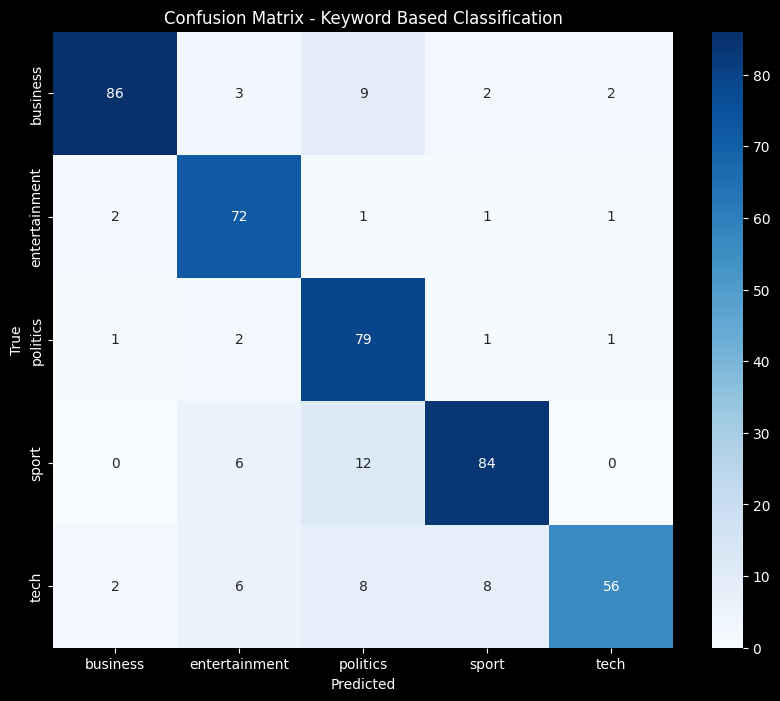


Average Precision by Category:
business: 0.9599
entertainment: 0.9392
politics: 0.8920
sport: 0.9476
tech: 0.9384


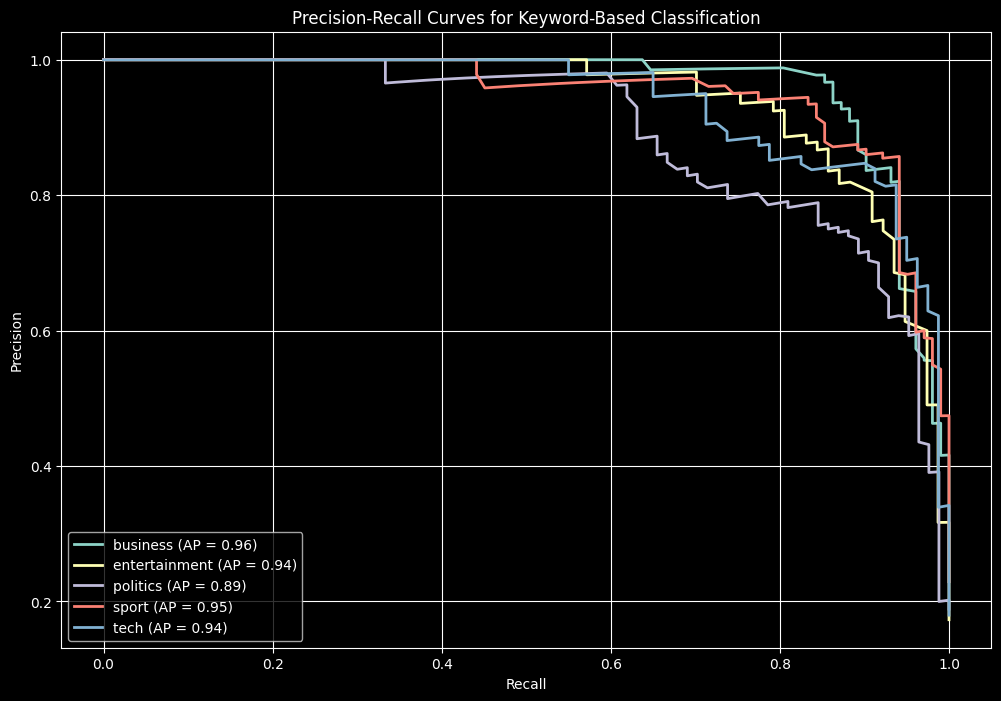


Model Interpretation:
--------------------
The keyword-based classifier makes decisions based on these distinctive terms:

BUSINESS category is characterized by:
1. 'bn'
2. 'said'
3. 'bank'
4. 'company'
5. 'economy'
6. 'year'
7. 'firm'
8. 'growth'
9. 'market'
10. 'sale'

ENTERTAINMENT category is characterized by:
1. 'film'
2. 'award'
3. 'best'
4. 'music'
5. 'show'
6. 'star'
7. 'band'
8. 'said'
9. 'year'
10. 'oscar'

POLITICS category is characterized by:
1. 'mr'
2. 'said'
3. 'labour'
4. 'election'
5. 'blair'
6. 'party'
7. 'tory'
8. 'government'
9. 'would'
10. 'minister'

SPORT category is characterized by:
1. 'game'
2. 'england'
3. 'win'
4. 'player'
5. 'match'
6. 'said'
7. 'cup'
8. 'injury'
9. 'final'
10. 'club'

TECH category is characterized by:
1. 'mobile'
2. 'game'
3. 'people'
4. 'technology'
5. 'phone'
6. 'said'
7. 'user'
8. 'computer'
9. 'software'
10. 'service'

Example Misclassifications Analysis:

MISCLASSIFICATION: Predicted as politics, actually sport

Text excerpt:
minist

In [24]:
# generate predictions using the keyword matching model
y_pred = predict_with_keywords(X_test, keyword_dict)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nKeyword-based Model Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_train),
            yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Keyword Based Classification')
plt.show()

# probability-based predictions for PR curves
y_pred, y_proba = predict_with_keywords_proba(X_test, keyword_dict)

# binarize the output for multi-class PR curves
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
n_classes = y_test_bin.shape[1]

# average precision for each class
average_precision = {}
for i, category in enumerate(np.unique(y_train)):
    average_precision[category] = average_precision_score(y_test_bin[:, i], y_proba[:, i])

print("\nAverage Precision by Category:")
for category, ap in average_precision.items():
    print(f"{category}: {ap:.4f}")

# plot PR curve for each class
plt.figure(figsize=(12, 8))
for i, category in enumerate(np.unique(y_train)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    ap = average_precision[category]
    plt.plot(recall, precision, lw=2,
             label=f'{category} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Keyword-Based Classification')
plt.legend(loc="best")
plt.grid(True)
plt.show()

# interpret the model by analyzing keyword importance
print("\nModel Interpretation:")
print("--------------------")
print("The keyword-based classifier makes decisions based on these distinctive terms:")
for category, keywords in keyword_dict.items():
    print(f"\n{category.upper()} category is characterized by:")
    for i, word in enumerate(keywords[:10], 1):
        print(f"{i}. '{word}'")

# some misclassifications
if isinstance(y_test, pd.Series):
    y_test_array = y_test.values
    y_pred_array = np.array(y_pred) if not isinstance(y_pred, np.ndarray) else y_pred

    # find misclassified examples
    misclassified_indices = np.where(y_pred_array != y_test_array)[0]

    if len(misclassified_indices) > 0:
        print("\nExample Misclassifications Analysis:")
        for idx in misclassified_indices[:3]:  # first 3 misclassifications
            true_cat = y_test.iloc[idx]
            pred_cat = y_pred[idx]
            print(f"\n{'='*60}")
            print(f"MISCLASSIFICATION: Predicted as {pred_cat}, actually {true_cat}")
            print(f"{'='*60}")

            # display the text content (limited to first 300 characters for readability)
            text = X_test[idx] if isinstance(X_test, np.ndarray) else X_test.iloc[idx]
            print("\nText excerpt:")
            print(f"{text[:300]}...")

            # count keywords from each category in this document
            print("\nKeyword counts by category:")
            for category, words in keyword_dict.items():
                word_counts = {word: text.count(word) for word in words if text.count(word) > 0}
                total_count = sum(word_counts.values())
                print(f"  {category}: {total_count} total matches")
                if word_counts:
                    print("    Keywords found:", ", ".join([f"{w}({c})" for w, c in word_counts.items()]))
            print(f"{'='*60}")
else:
    misclassified_indices = np.where(np.array(y_pred) != np.array(y_test))[0]
    if len(misclassified_indices) > 0:
        print("\nExample Misclassifications Analysis:")
        for idx in misclassified_indices[:3]:
            true_cat = y_test[idx]
            pred_cat = y_pred[idx]
            print(f"\n{'='*60}")
            print(f"MISCLASSIFICATION: Predicted as {pred_cat}, actually {true_cat}")
            print(f"{'='*60}")
            text = X_test[idx]
            print("\nText excerpt:")
            print(f"{text[:300]}...")

            print("\nKeyword counts by category:")
            for category, words in keyword_dict.items():
                word_counts = {word: text.count(word) for word in words if text.count(word) > 0}
                total_count = sum(word_counts.values())
                print(f"  {category}: {total_count} total matches")

                if word_counts:
                    print("    Keywords found:", ", ".join([f"{w}({c})" for w, c in word_counts.items()]))
            print(f"{'='*60}")

The keyword-based classification model achieved a solid accuracy of 84.7% on the BBC dataset, which is impressive considering the simplicity of the approach. The model demonstrates balanced performance across precision (0.86) and recall (0.85), indicating it's effective at both identifying relevant documents and avoiding false positives.

### Strengths:

Business category shows the highest precision (0.95) and F1-score (0.89), suggesting the keywords for this category (like "bn", "bank", "company") are highly distinctive.
Entertainment has the highest recall (0.94) alongside Politics, meaning it rarely misses articles in this category.
Average Precision scores are strong across all categories (>0.89), with Business scoring the highest at 0.96.

### Weaknesses:

Tech category has the lowest recall (0.70), meaning about 30% of tech articles are misclassified as something else.
Politics category has the lowest precision (0.72), indicating it generates the most false positives.

Common keywords across categories: "said" appears in all five categories, making it less useful for discrimination. We should have handled this in the preprocess or go back and take it out now. Potential overlaps: "game" appears in both Tech and Sport, potentially causing confusion between these categories.

### Highly distinctive keywords:
Business: financial terms ("bn", "bank", "market")
Entertainment: media terms ("film", "award", "oscar")
Politics: government terms ("labour", "election", "minister")
Sport: athletic terms ("game", "win", "match")
Tech: technology terms ("mobile", "technology", "computer")

### Misclassification Analysis
The examples reveal three key limitations of the keyword-based approach:

- Context blindness: In the first example, a "sport minister" article is classified as politics because the model doesn't understand that "minister" in this context relates to sports. The model counts keywords but doesn't grasp their relationships.
- Vocabulary overlap: The second example (PSP console) demonstrates how gaming-related terms overlap between Tech and Sport. The model doesn't understand that "game" in this context refers to video games (tech) rather than sporting events.
- Named entity confusion: In the third example, "PeopleSoft" (a company name) is likely being counted as multiple instances of the politics keyword "people", causing a business article to be misclassified as politics.

### Conclusions

1. Strong baseline performance: The keyword-based model provides a solid benchmark (84.7% accuracy) with complete transparency.
2. Inherent limitations: The model struggles with:
Articles that naturally span multiple categories,
Context-dependent word meanings,
Named entities that contain common keywords

## 2.2 RoBERTa Evaluation & Interpretation


Final evaluation:



Classification Report:
               precision    recall  f1-score   support

     business       0.95      0.99      0.97       102
entertainment       0.97      0.97      0.97        77
     politics       0.99      0.93      0.96        84
        sport       1.00      1.00      1.00       102
         tech       0.96      0.97      0.97        80

     accuracy                           0.98       445
    macro avg       0.98      0.97      0.97       445
 weighted avg       0.98      0.98      0.98       445



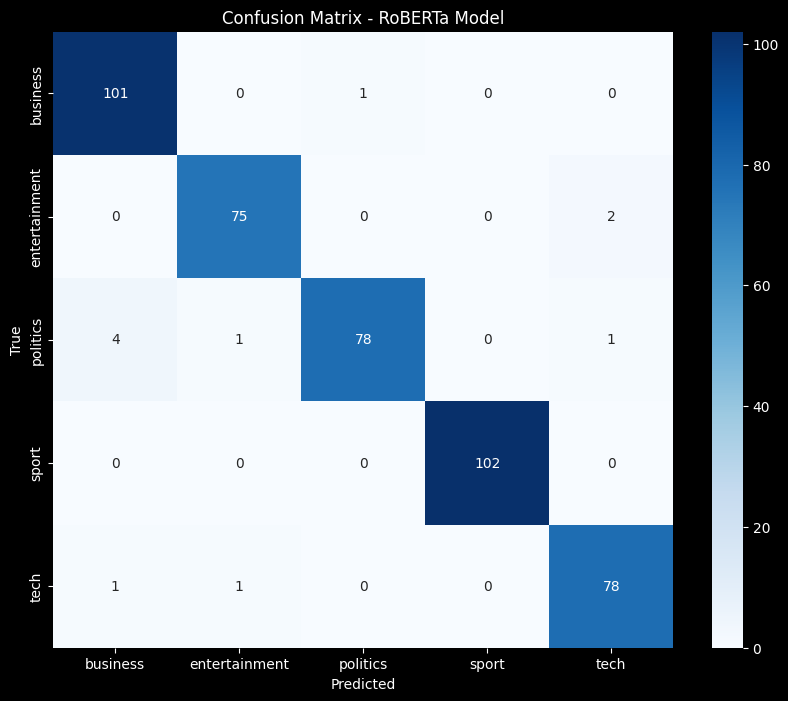


Calculating prediction probabilities for PR curves...



Average Precision (AUPR) by Category:
business: 0.9902
entertainment: 0.9992
politics: 0.9883
sport: 1.0000
tech: 0.9982


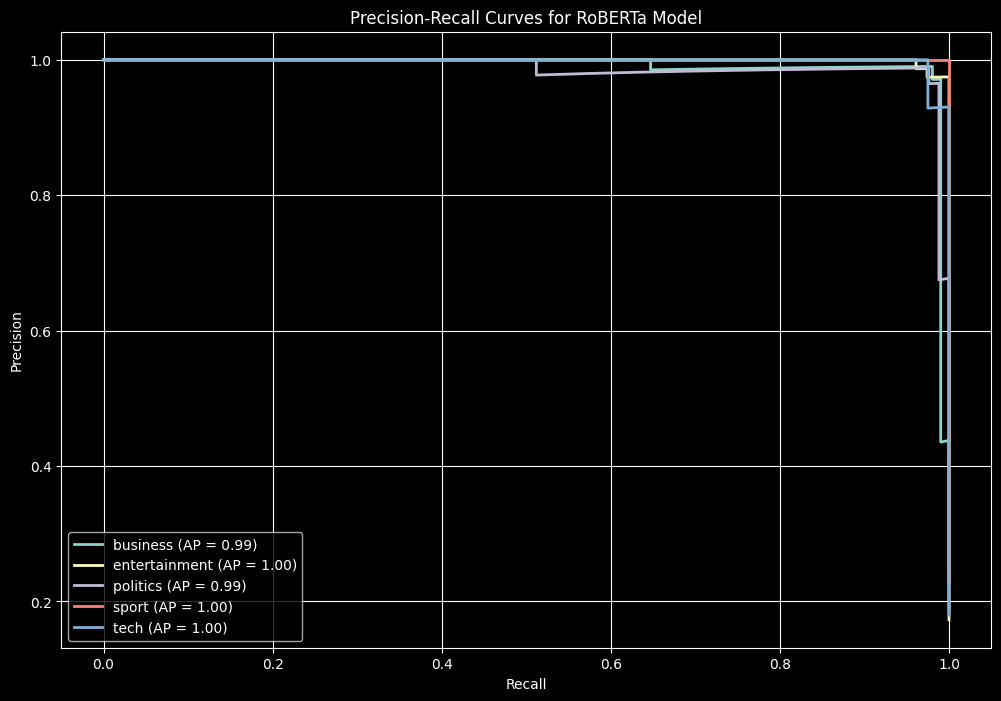


Testing with examples:

Text: French suitor holds LSE meeting

European stock market Euronext has met with the London Stock Exchange (LSE) amid speculation that it may be ready to ...
Predicted category: business

Text: Durex maker SSL awaits firm bid

UK condom maker SSL International has refused to comment on reports it may be subject to a takeover early in 2005.

A...
Predicted category: business

Text: Singer's film to show at festival

A documentary which takes a candid look at the life of chart-topping singer George Michael will be shown at this ye...
Predicted category: entertainment

Interpreting model predictions with LIME:

LIME Explanation Example:
Text: French suitor holds LSE meeting

European stock market Euronext has met with the London Stock Exchange (LSE) amid speculation that it may be ready to ...
Predicted category: business

Features supporting the prediction:
Deutsche: -0.0004
held: -0.0003
Friday: -0.0003
jobs: -0.0003
Unions: -0.0003
Commentators: -0.0003
repor

<Figure size 1200x600 with 0 Axes>

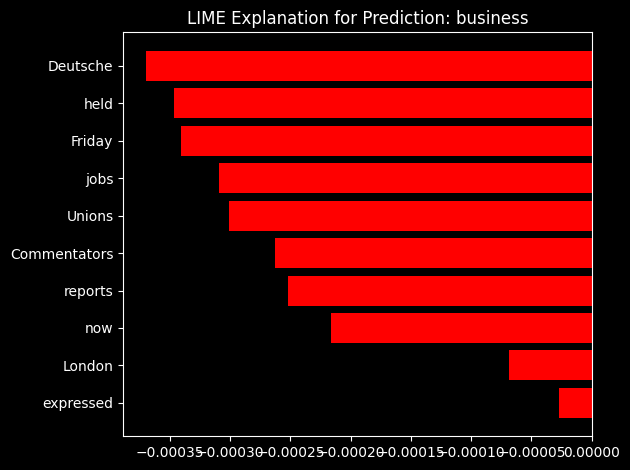


Interpreting model predictions with Shapley Values:

Shapley Value Explanation Example:
Text: Durex maker SSL awaits firm bid

UK condom maker SSL International has refused to comment on reports it may be subject to a takeover early in 2005.

A...
Analyzing first 50 words: Durex maker SSL awaits firm bid UK condom maker SSL International has refused to comment on reports it may be subject to a takeover early in 2005. A Financial Times report said business intelligence firm GPW was understood to be starting due diligence work on SSL International, for a corporate
Predicted category: business

Top 15 words by Shapley Value contribution:
International: 0.1500
has: 0.1500
subject: -0.1500
takeover: 0.1500
Financial: 0.1500
intelligence: -0.1500
firm: 0.1500
diligence: 0.1500
firm: 0.1000
bid: 0.1000
SSL: -0.1000
refused: -0.1000
in: 0.1000
report: 0.1000
was: -0.1000


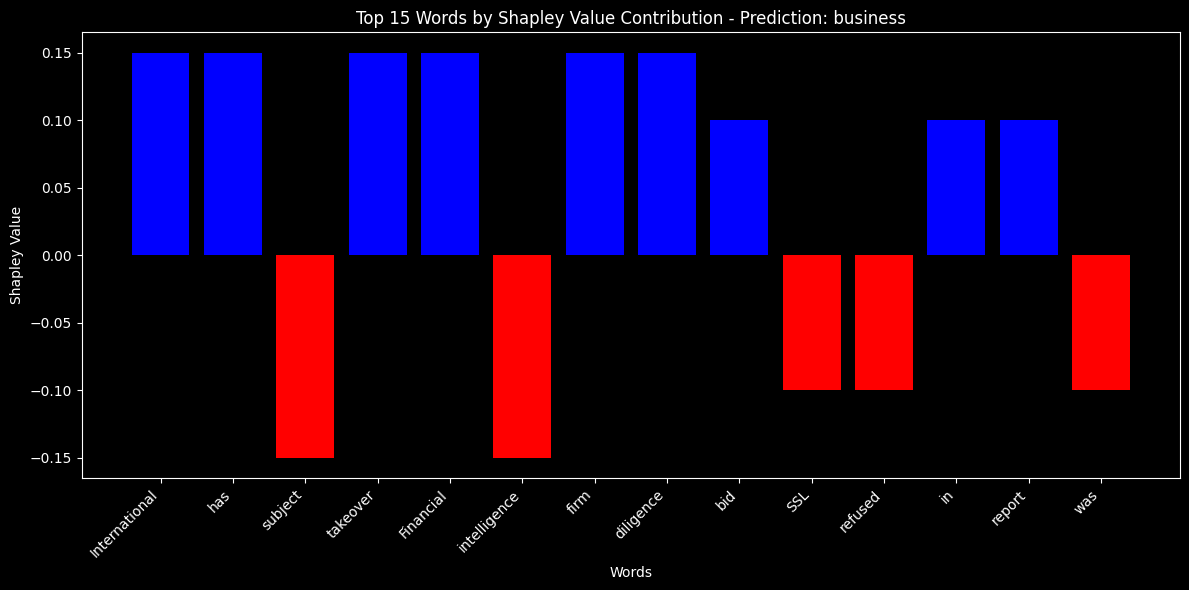

In [31]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    return predictions, actual_labels

# final evaluation
print("\nFinal evaluation:")
predictions, actual_labels = evaluate(model, test_loader, device)
# convert numerical labels back to original categories
predicted_categories = label_encoder.inverse_transform(predictions)
actual_categories = label_encoder.inverse_transform(actual_labels)

print("\nClassification Report:")
print(classification_report(actual_categories, predicted_categories))

# confusion matrix
cm = confusion_matrix(actual_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RoBERTa Model')
plt.show()

# get prediction probabilities from RoBERTa
def get_prediction_probabilities(model, data_loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Getting probabilities", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.extend(labels.cpu().tolist())

    all_probs = np.vstack(all_probs)

    return all_probs, all_labels

print("\nCalculating prediction probabilities for PR curves...")
y_proba, y_test_original = get_prediction_probabilities(
    model,
    test_loader,
    device
)

y_test_bin = label_binarize(y_test_original, classes=range(len(label_encoder.classes_)))
n_classes = y_test_bin.shape[1]
average_precision = {}
for i, category in enumerate(label_encoder.classes_):
    average_precision[category] = average_precision_score(y_test_bin[:, i], y_proba[:, i])

print("\nAverage Precision (AUPR) by Category:")
for category, ap in average_precision.items():
    print(f"{category}: {ap:.4f}")

plt.figure(figsize=(12, 8))
for i, category in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    ap = average_precision[category]
    plt.plot(recall, precision, lw=2,
             label=f'{category} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for RoBERTa Model')
plt.legend(loc="best")
plt.grid(True)
plt.show()

# example prediction function
def predict_category(text, model, tokenizer, label_encoder, device, max_length=256):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

    predicted_label = preds.item()
    predicted_category = label_encoder.inverse_transform([predicted_label])[0]

    return predicted_category

# test the model with some examples
print("\nTesting with examples:")
test_examples = X_test[:3]
for text in test_examples:
    category = predict_category(text, model, tokenizer, label_encoder, device)
    print(f"\nText: {text[:150]}...")
    print(f"Predicted category: {category}")

# model Interpretation using LIME
print("\nInterpreting model predictions with LIME:")

def interpret_prediction_with_lime(text, model, tokenizer, label_encoder, device, num_features=10):
    # get model prediction and class names
    category = predict_category(text, model, tokenizer, label_encoder, device)
    class_names = label_encoder.classes_

    # pipeline for LIME explainer
    def predict_fn(texts):
        results = []
        for text in texts:
            encoding = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=256,
                return_token_type_ids=False,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt',
            )

            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                probs = F.softmax(outputs.logits, dim=1)
                results.append(probs.cpu().numpy()[0])

        return np.array(results)

    explainer = LimeTextExplainer(class_names=class_names)

    exp = explainer.explain_instance(
        text,
        predict_fn,
        num_features=num_features,
        num_samples=1000
    )

    return exp, category

# apply LIME to a test example
print("\nLIME Explanation Example:")
test_example = X_test[0]
explanation, category = interpret_prediction_with_lime(test_example, model, tokenizer, label_encoder, device)

print(f"Text: {test_example[:150]}...")
print(f"Predicted category: {category}")
print("\nFeatures supporting the prediction:")
for feature, weight in explanation.as_list():
    print(f"{feature}: {weight:.4f}")

plt.figure(figsize=(12, 6))
explanation.as_pyplot_figure()
plt.title(f'LIME Explanation for Prediction: {category}')
plt.tight_layout()
plt.show()

# model interpretation using Shapley Value sampling
print("\nInterpreting model predictions with Shapley Values:")

def get_word_attributions_shapley(text, model, tokenizer, label_encoder, device, num_samples=50):
    """
    A simpler implementation of Shapley Value sampling for text classification.
    This method uses a sampling approach to estimate Shapley values.
    """
    # tokenize the text
    words = text.split()
    n_words = len(words)

    # get the prediction for the full text
    predicted_label_idx = predict_category(text, model, tokenizer, label_encoder, device)
    predicted_label = label_encoder.transform([predicted_label_idx])[0]
    shapley_values = np.zeros(n_words)

    def get_prediction(text_sample):
        pred = predict_category(text_sample, model, tokenizer, label_encoder, device)
        pred_idx = label_encoder.transform([pred])[0]
        return 1 if pred_idx == predicted_label else 0

    empty_text = "."
    baseline_pred = get_prediction(empty_text)

    # sampling approach to estimate Shapley values
    for _ in range(num_samples):
        # random permutation of word indices
        perm = np.random.permutation(n_words)

        # incrementally add words according to the permutation
        for i in range(n_words):
            # create a subset with words up to index i in the permutation
            subset_indices = perm[:i+1]

            # create text with only this subset of words
            subset_words = [words[idx] for idx in subset_indices]
            subset_text = ' '.join(subset_words)

            # text without the current word
            prev_subset_indices = perm[:i]
            prev_subset_words = [words[idx] for idx in prev_subset_indices]
            prev_subset_text = ' '.join(prev_subset_words) if prev_subset_words else empty_text

            # calculate marginal contribution
            current_pred = get_prediction(subset_text)
            prev_pred = get_prediction(prev_subset_text)

            # add marginal contribution to word's Shapley value
            word_idx = perm[i]
            shapley_values[word_idx] += (current_pred - prev_pred) / num_samples

    # Pair words with their Shapley values
    word_attributions = list(zip(words, shapley_values))
    # sort by absolute contribution
    word_attributions.sort(key=lambda x: abs(x[1]), reverse=True)

    return word_attributions, predicted_label_idx

print("\nShapley Value Explanation Example:")
test_example = X_test[1]
print(f"Text: {test_example[:150]}...")

sample_text = ' '.join(test_example.split()[:50])
print(f"Analyzing first 50 words: {sample_text}")

word_attributions, predicted_class = get_word_attributions_shapley(
    sample_text, model, tokenizer, label_encoder, device, num_samples=20
)

print(f"Predicted category: {predicted_class}")
print("\nTop 15 words by Shapley Value contribution:")
for word, value in word_attributions[:15]:
    print(f"{word}: {value:.4f}")

plt.figure(figsize=(12, 6))
words, values = zip(*word_attributions[:15])
colors = ['red' if v < 0 else 'blue' for v in values]
plt.bar(words, values, color=colors)
plt.xlabel('Words')
plt.ylabel('Shapley Value')
plt.title(f'Top 15 Words by Shapley Value Contribution - Prediction: {predicted_class}')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


--- LIME Analysis for 'business' category ---

Text excerpt: French suitor holds LSE meeting

European stock market Euronext has met with the London Stock Exchange (LSE) amid speculation that it may be ready to launch a cash bid.

Euronext chief Jean-Francois Theodore held talks with LSE boss Clara Furse the day after rival Deutsche Boerse put forward its own bid case. The German exchange said it had held "constructive, professional and friendly" talks with the LSE. But Euronext declined to comment after the talks ended on Friday. Speculation is mounting ...
Predicted category: business

Features supporting the prediction:
Deutsche: -0.0003
Euronext: -0.0003
stock: -0.0002
fears: -0.0002
sweeteners: -0.0002
talks: -0.0002
equities: -0.0002
LSE: -0.0002
more: -0.0002
take: -0.0001
as: -0.0001
either: -0.0000
fear: -0.0000
moved: 0.0000
holds: 0.0000


<Figure size 1000x500 with 0 Axes>

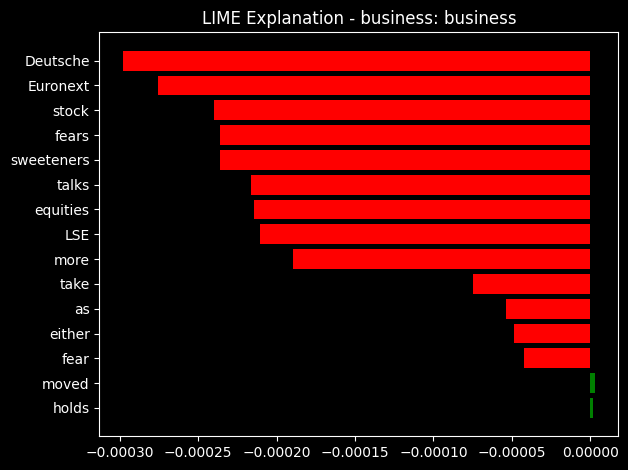


--- LIME Analysis for 'entertainment' category ---

Text excerpt: Singer's film to show at festival

A documentary which takes a candid look at the life of chart-topping singer George Michael will be shown at this year's Berlin Film Festival.

A Different Story will screen in the Panorama section of the festival, which runs from 10-20 February. It features the singer talking about both his career and his personal life, from his days in Wham! through to more recent events. Michael will attend the festival to introduce the screening on 16 February. Director Sout...
Predicted category: entertainment

Features supporting the prediction:
George: 0.0072
Fiennes: 0.0065
Elton: 0.0063
Singer: 0.0061
of: 0.0060
film: 0.0060
Panorama: 0.0058
Berlin: 0.0057
about: 0.0054
singers: 0.0052
stance: -0.0015
Festival: -0.0013
personal: 0.0012
Joseph: 0.0006
against: 0.0003


<Figure size 1000x500 with 0 Axes>

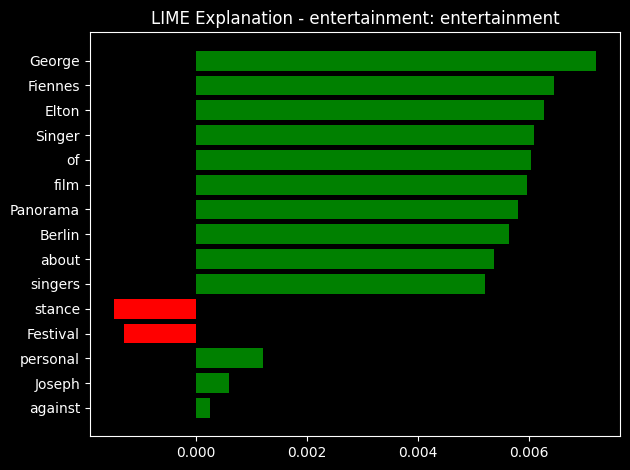


--- LIME Analysis for 'politics' category ---

Text excerpt: Brown hits back in Blair rift row

Gordon Brown has criticised a union leader who said conflict between himself and Tony Blair was harming the workings of government.

Jonathan Baume, of the top civil servants' union, spoke of "competing agendas" between Mr Brown and Mr Blair. But the chancellor said Mr Baume was never at meetings between himself and the prime minister so could not judge. He said the union leader was trying to block civil service reform which threatened his members' jobs. It sui...
Predicted category: politics

Features supporting the prediction:
Blair: -0.0022
Brown: -0.0016
was: -0.0016
Mr: -0.0014
present: -0.0014
savings: -0.0014
the: -0.0012
service: -0.0011
members: -0.0010
some: -0.0010
value: -0.0008
purpose: 0.0002
both: 0.0001
but: 0.0000
taxpayers: 0.0000


<Figure size 1000x500 with 0 Axes>

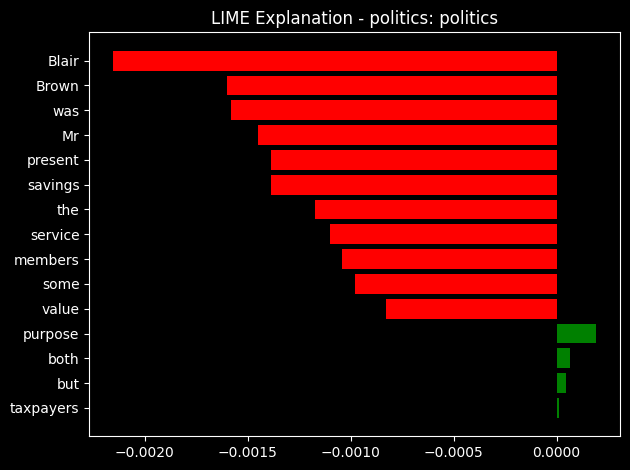


--- LIME Analysis for 'sport' category ---

Text excerpt: McClaren targets Champions League

Middlesbrough boss Steve McClaren believes his side can clinch a top-four spot in the Premiership and secure qualification for the Champions League.

After their 3-2 win over Manchester City, McClaren said: "We are playing exciting football, it's a magnificent result to keep us in the top five. "But how well we do depends how often we can get our best team out. "Once we got the third goal it should have been four or five but we nearly paid for it in the end." M...
Predicted category: sport

Features supporting the prediction:
Champions: -0.0016
clinch: -0.0014
McClaren: -0.0014
been: -0.0014
winger: -0.0013
trying: -0.0012
3: -0.0012
their: 0.0012
League: -0.0011
Manchester: -0.0011
goal: -0.0010
exciting: -0.0010
our: -0.0008
Hasselbaink: 0.0007
do: 0.0004


<Figure size 1000x500 with 0 Axes>

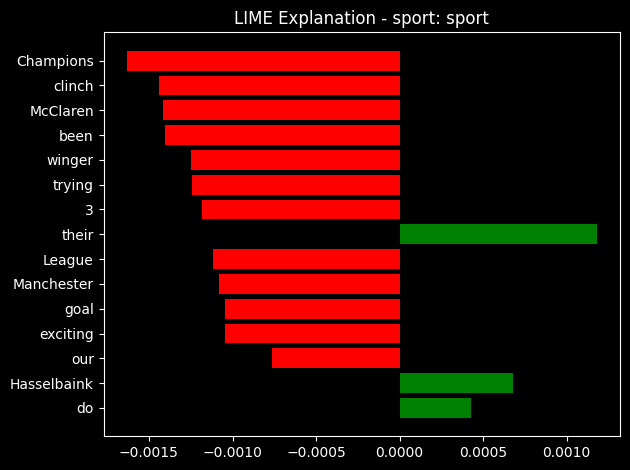


--- LIME Analysis for 'tech' category ---

Text excerpt: More power to the people says HP

The digital revolution is focused on letting people tell and share their own stories, according to Carly Fiorina, chief of technology giant Hewlett Packard.

The job of firms such as HP now, she said in a speech at the Consumer Electronics Show (CES), was to ensure digital and physical worlds fully converged. She said the goal for 2005 was to make people the centre of technology. CES showcases 50,000 new gadgets that will be hitting the shelves in 2005. The tech...
Predicted category: tech

Features supporting the prediction:
portable: -0.0005
digital: -0.0005
technology: -0.0005
players: -0.0004
control: -0.0004
remain: -0.0003
HP: -0.0003
of: -0.0003
theme: -0.0002
Consumer: -0.0002
focus: -0.0001
MP3: -0.0001
summer: -0.0000
shelves: -0.0000
own: -0.0000


<Figure size 1000x500 with 0 Axes>

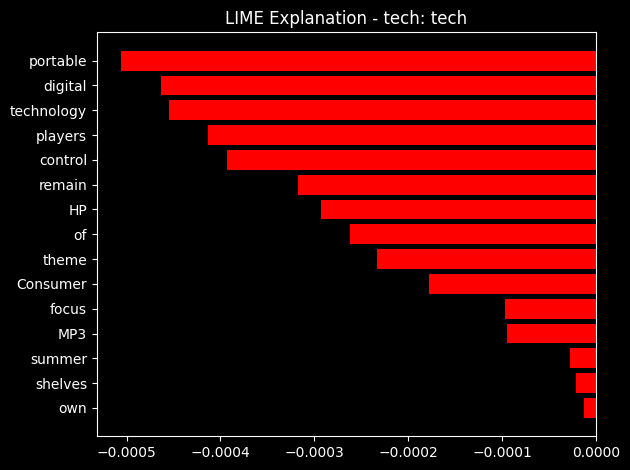



== SHAPLEY ANALYSIS ACROSS CATEGORIES ==


--- Shapley Analysis for 'business' category ---

Text excerpt: French suitor holds LSE meeting

European stock market Euronext has met with the London Stock Exchange (LSE) amid speculation that it may be ready to launch a cash bid.

Euronext chief Jean-Francois Theodore held talks with LSE boss Clara Furse the day after rival Deutsche Boerse put forward its own bid case. The German exchange said it had held "constructive, professional and friendly" talks with the LSE. But Euronext declined to comment after the talks ended on Friday. Speculation is mounting ...
Predicted category: business

Top words by Shapley Value contribution:
LSE: 0.1333
bid.: 0.1000
LSE: 0.1000
its: 0.1000
stock: 0.0667
market: 0.0667
to: -0.0667
cash: 0.0667
Euronext: 0.0667
held: 0.0667


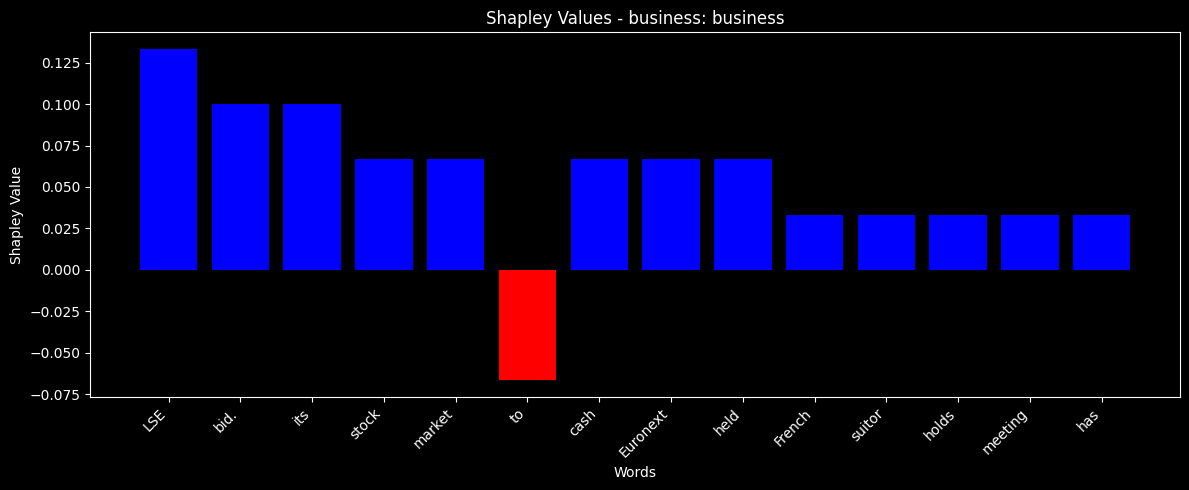


--- Shapley Analysis for 'entertainment' category ---

Text excerpt: Singer's film to show at festival

A documentary which takes a candid look at the life of chart-topping singer George Michael will be shown at this year's Berlin Film Festival.

A Different Story will screen in the Panorama section of the festival, which runs from 10-20 February. It features the singer talking about both his career and his personal life, from his days in Wham! through to more recent events. Michael will attend the festival to introduce the screening on 16 February. Director Sout...
Predicted category: entertainment

Top words by Shapley Value contribution:
singer: 0.1667
film: 0.1333
festival: 0.1333
Festival.: 0.1333
Film: 0.1000
festival,: 0.1000
Story: 0.0667
screen: -0.0667
Panorama: 0.0667
Singer's: 0.0333


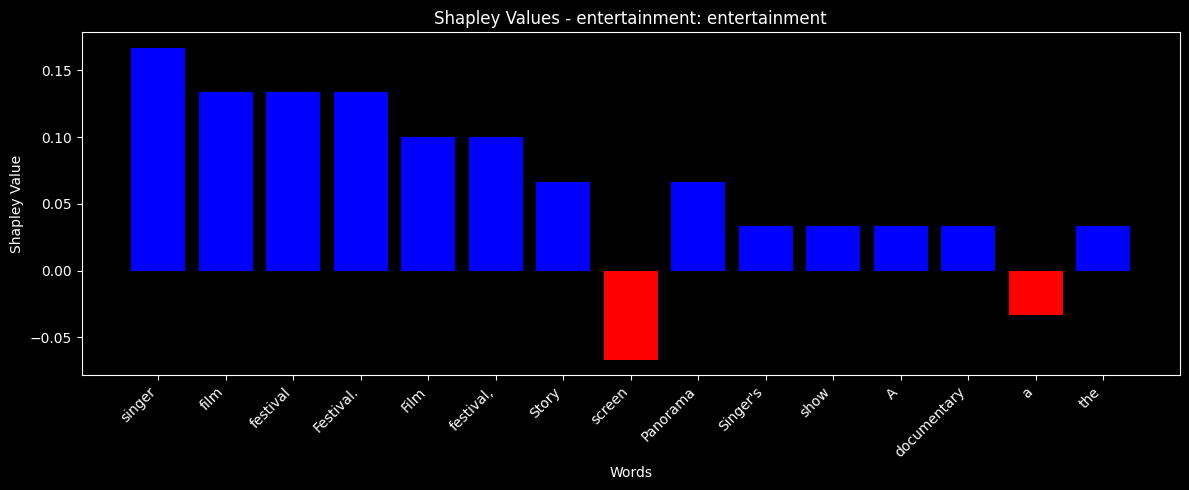


--- Shapley Analysis for 'politics' category ---

Text excerpt: Brown hits back in Blair rift row

Gordon Brown has criticised a union leader who said conflict between himself and Tony Blair was harming the workings of government.

Jonathan Baume, of the top civil servants' union, spoke of "competing agendas" between Mr Brown and Mr Blair. But the chancellor said Mr Baume was never at meetings between himself and the prime minister so could not judge. He said the union leader was trying to block civil service reform which threatened his members' jobs. It sui...
Predicted category: politics

Top words by Shapley Value contribution:
Blair.: 0.1667
Blair: 0.1333
Mr: 0.1333
Mr: 0.1333
government.: 0.1000
chancellor: 0.1000
Brown: 0.0667
Gordon: 0.0667
Baume,: -0.0667
back: 0.0333


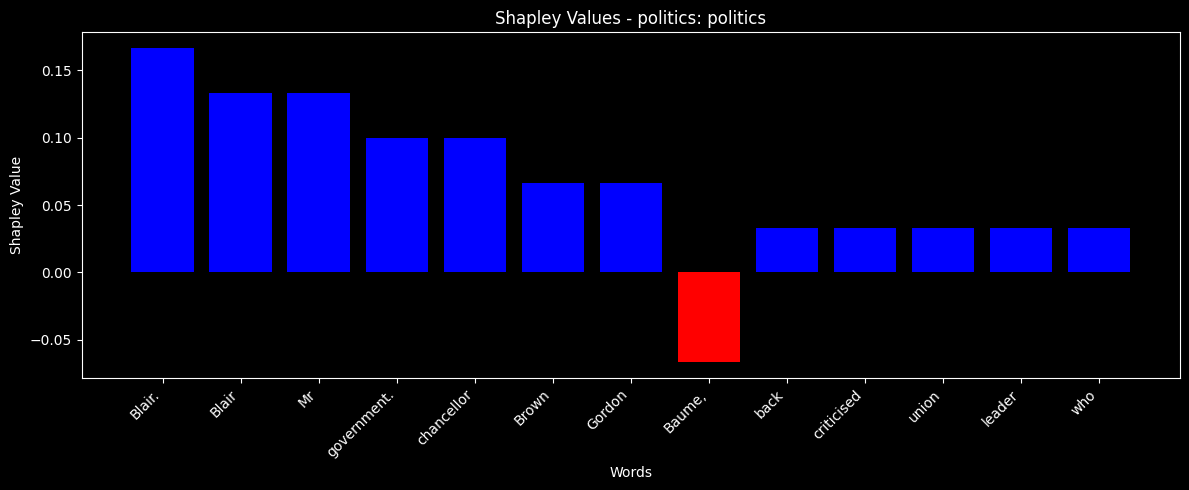


--- Shapley Analysis for 'sport' category ---

Text excerpt: McClaren targets Champions League

Middlesbrough boss Steve McClaren believes his side can clinch a top-four spot in the Premiership and secure qualification for the Champions League.

After their 3-2 win over Manchester City, McClaren said: "We are playing exciting football, it's a magnificent result to keep us in the top five. "But how well we do depends how often we can get our best team out. "Once we got the third goal it should have been four or five but we nearly paid for it in the end." M...
Predicted category: sport

Top words by Shapley Value contribution:
clinch: 0.1000
McClaren: 0.1000
football,: 0.1000
keep: 0.1000
Champions: 0.0667
League: 0.0667
McClaren: 0.0667
side: 0.0667
Premiership: 0.0667
3-2: 0.0667


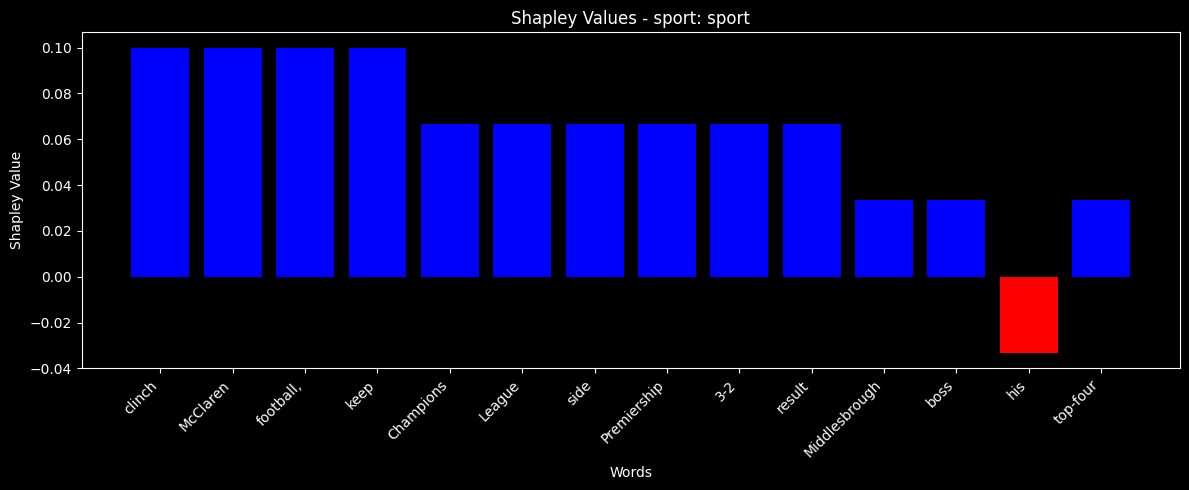


--- Shapley Analysis for 'tech' category ---

Text excerpt: More power to the people says HP

The digital revolution is focused on letting people tell and share their own stories, according to Carly Fiorina, chief of technology giant Hewlett Packard.

The job of firms such as HP now, she said in a speech at the Consumer Electronics Show (CES), was to ensure digital and physical worlds fully converged. She said the goal for 2005 was to make people the centre of technology. CES showcases 50,000 new gadgets that will be hitting the shelves in 2005. The tech...
Predicted category: business

Top words by Shapley Value contribution:
Hewlett: 0.3000
technology: -0.2333
firms: 0.2000
share: 0.1333
chief: 0.1333
of: 0.1333
says: 0.0667
stories,: -0.0667
Fiorina,: 0.0667
giant: 0.0667


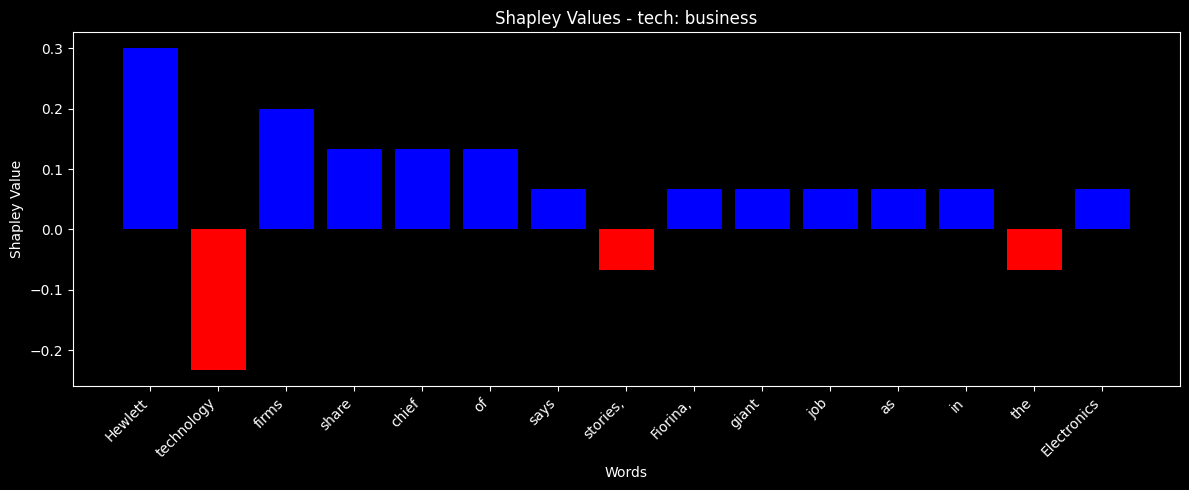

In [33]:
# 1. multiple examples from each category using lime
def select_category_examples(X_test, y_test, label_encoder, num_per_category=2):
    """
    Select examples from each category for interpretation analysis
    """
    examples = {}
    for category_idx, category in enumerate(label_encoder.classes_):
        # Find indices of examples in this category
        category_indices = np.where(y_test == category_idx)[0]

        # Select 'num_per_category' examples for this category
        if len(category_indices) >= num_per_category:
            selected_indices = category_indices[:num_per_category]
            examples[category] = [(idx, X_test[idx]) for idx in selected_indices]

    return examples

category_examples = select_category_examples(X_test, y_test, label_encoder, num_per_category=1)
lime_features_by_category = {category: [] for category in label_encoder.classes_}

for category, examples in category_examples.items():
    print(f"\n--- LIME Analysis for '{category}' category ---")

    for idx, text in examples:
        print(f"\nText excerpt: {text[:500]}...")
        explanation, predicted = interpret_prediction_with_lime(
            text, model, tokenizer, label_encoder, device, num_features=15
        )

        print(f"Predicted category: {predicted}")
        print("\nFeatures supporting the prediction:")
        feature_weights = explanation.as_list()

        lime_features_by_category[category].extend(
            [(feature, weight) for feature, weight in feature_weights]
        )

        for feature, weight in feature_weights:
            print(f"{feature}: {weight:.4f}")

        plt.figure(figsize=(10, 5))
        explanation.as_pyplot_figure()
        plt.title(f'LIME Explanation - {category}: {predicted}')
        plt.tight_layout()
        plt.show()

# 2. Shapley analysis
print("\n\n== SHAPLEY ANALYSIS ACROSS CATEGORIES ==\n")
shapley_features_by_category = {category: [] for category in label_encoder.classes_}
for category, examples in category_examples.items():
    print(f"\n--- Shapley Analysis for '{category}' category ---")

    for idx, text in examples:
        print(f"\nText excerpt: {text[:500]}...")
        sample_text = ' '.join(text.split()[:50])

        word_attributions, predicted = get_word_attributions_shapley(
            sample_text, model, tokenizer, label_encoder, device, num_samples=30
        )

        print(f"Predicted category: {predicted}")

        shapley_features_by_category[category].extend(
            [(word, value) for word, value in word_attributions if abs(value) > 0.05]
        )

        print("\nTop words by Shapley Value contribution:")
        for word, value in word_attributions[:10]:
            print(f"{word}: {value:.4f}")

        plt.figure(figsize=(12, 5))
        words, values = zip(*word_attributions[:15])
        colors = ['red' if v < 0 else 'blue' for v in values]
        plt.bar(words, values, color=colors)
        plt.xlabel('Words')
        plt.ylabel('Shapley Value')
        plt.title(f'Shapley Values - {category}: {predicted}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

RoBERTa classifier demonstrates exceptional performance on the BBC dataset, achieving 98% overall accuracy. This represents a considerable improvement over the keyword-based model's 84.7% accuracy.
Near-perfect classification for all five categories, with F1-scores ranging from 0.96 to 1.00
Perfect precision and recall (1.00) for the Sport category
Very high precision (0.95-1.00) across all categories, indicating minimal false positives.
Strong recall values (0.93-1.00), showing the model rarely misses articles in their correct categories.
The most challenging category appears to be Politics with a slightly lower recall (0.93), suggesting the model occasionally misclassifies some political articles as belonging to other categories.

### Model Interpretation

While RoBERTa's performance is impressive, its black box nature makes it challenging to understand how it reaches its decisions.

### LIME Analysis

The model often assigns surprisingly small weight magnitudes to individual words, even ones that seem intuitively important to the classification task.
Many finance-related and business terms receive negative rather than positive weights in LIME analysis, contrary to what one might expect.
Technical domain-specific vocabulary doesn't appear to strongly influence the model's decisions in isolation for a few examples.
The small magnitude of feature weights consistently suggests that RoBERTa isn't heavily dependent on individual keywords for classification.

- These findings suggest that RoBERTa's decision-making relies on complex patterns beyond individual keywords.
- Utilizes contextual relationships between terms rather than their mere presence.
- Bases decisions on holistic semantic understanding rather than specific trigger words.
- May be considering word sequences and relationships that LIME cannot easily capture.

### Shapley Value Analysis

Domain-specific terminology consistently shows importance across examples, but with varying contribution signs. Brand names and entity references often emerge as significant contributors to classification decisions. Financial and technical terms typically receive higher attribution scores than general vocabulary. The magnitude of Shapley values tends to be larger than LIME values, suggesting more decisive attribution patterns. Certain category-specific terminologies appear consistently important across multiple examples.

The Shapley analysis indicates that while individual words do influence RoBERTa's decisions, their impact is highly contextual and depends on their relationship to other terms in the document.

# 3. Whitebox - blackbox comparison

This notebook compared two fundamentally different approaches to text classification: a simple keyword-based model representing whitebox (interpretable) methods, and a RoBERTa transformer model representing blackbox (complex but high-performing) methods.

The RoBERTa model significantly outperformed the keyword-based approach, achieving 98% accuracy compared to 84.7% for the keyword method. This performance gap highlights the power of contextual embeddings and deep learning architectures in capturing the nuanced semantic relationships in text.

While RoBERTa delivers superior performance, the keyword-based approach offers clear advantages in interpretability.

Keyword-Based Model (Whitebox)

- Transparent Decision Process: Classification is based on simple word frequency counts using a predefined set of category-specific keywords.
- Intuitive Understanding: The model's decisions can be easily traced to the presence of specific words, making errors straightforward to diagnose.
- Low Complexity: Implementation requires minimal computational resources and training time.
- Direct Feature Importance: The importance of each keyword is directly measurable by its TF-IDF score.

RoBERTa Model (Blackbox)

- Contextual Understanding: Captures semantic relationships and contextual word meanings that the keyword approach misses.
- Complex Decision Boundaries: Uses deep neural networks with millions of parameters, making decisions difficult to trace.
- Resource Intensive: Requires significant computational resources for training and inference.
- Indirect Feature Attribution: Requires post-hoc methods like LIME and Shapley values to provide approximate explanations of decisions.

The models' errors reveal fundamental differences in their approaches to text classification.

The Keyword-Based Model cannot distinguish between different uses of the same word (e.g., "minister" in politics vs. sports contexts). It struggles with terms that appear across multiple categories (e.g., "game" in tech vs. sport).Misinterprets company or proper names that contain common keywords. Performance is heavily depends on the number of keywords selected per category.

The choice between whitebox and blackbox models involves important practical considerations:

When to Use Keyword-Based Models:
- Applications requiring complete transparency in decision-making
- Domains with strict regulatory requirements for explainability
- Resource-constrained environments
- When simple, rule-based classifications are sufficient (for example this dataset was an "easy" from the text classification point of view)

When to Use RoBERTa or Similar Models:
- When accuracy is the priority over explainability
- When handling complex, nuanced text with context-dependent meanings
- When sufficient computational resources are available
- In applications where false positives/negatives have lower stakes

The significant performance gap between these approaches highlights the fundamental tradeoff in machine learning between accuracy and interpretability. While RoBERTa achieves near-perfect classification performance, the keyword-based model provides a level of transparency that may be essential in high-stakes applications where understanding the "why" behind predictions is as important as the predictions themselves.

# 4. Ethical AI survey


## 4.1. Human Agency and Oversight

### Current Implementation Status
- Both models were developed for comparative analysis and not yet deployed in decision-making systems
- Both models could potentially be integrated into automated content classification systems that might affect human decisions
- No oversight mechanisms currently implemented beyond accuracy metrics

### Actions to take
- Implement human-in-the-loop validation for any deployment scenario, especially for the RoBERTa model
- Design a user interface that clearly communicates to end-users when content has been classified by an AI system
- Develop a feedback mechanism allowing humans to contest and override model classifications
- Document clear limitations of both models to prevent overreliance in critical applications

## 4.2. Privacy and Data Governance

### Current Implementation Status
- BBC dataset is a public dataset commonly used for academic purposes
- No explicit privacy assessment conducted on the training data
- No data minimization strategies implemented yet

### Actions to take
- Conduct an audit of the BBC dataset to identify potential biases in article representation
- Implement data minimization principles by documenting which features are actually necessary for classification
- Establish a data governance framework for any potential deployment that includes:
  - Clear data retention policies
  - Processing transparency documentation
  - Regular bias monitoring in the data pipeline

## 4.3. Transparency

### Current Implementation Status
- Keyword-based model offers high transparency (explicit word-frequency relationships)
- RoBERTa model operates as a black box with limited interpretability
- Current documentation explains the general approach but doesn't provide detailed explanations for individual decisions

### Actions to take
- Enhance documentation of both models to include specific limitations and potential failure modes
- Develop a model card that clearly documents:
  - Training data characteristics
  - Performance metrics across different categories
  - Potential biases and limitations
  - Confidence metrics for predictions
- Create visualization tools that make the classification process more transparent to non-technical users

## 4.4. Fairness, Diversity, and Non-discrimination

### Current Implementation Status
- No explicit fairness assessment conducted
- No analysis of potential biases in how different topics are represented
- No evaluation of the models' performance across diverse content creators or viewpoints

### Actions to take
- Evaluate both models for potential biases in classification accuracy across:
  - Different writing styles
  - Content from diverse authors
  - Regional linguistic variations
- Test for and mitigate potential content misclassification that could affect representation of minority viewpoints
- Implement fairness metrics as part of the evaluation pipeline
- Consider augmenting training data to ensure balanced representation

## 4.5. Societal and Environmental Well-being

### Current Implementation Status
- Limited assessment of broader societal implications of automated text classification
- No consideration of how automated classification might affect media consumption
- No environmental impact assessment of model training and deployment

### Actions to take
- Conduct an impact assessment on how automated classification might affect:
  - Media diversity and content presentation
  - Information access for different demographic groups
- Document the computational resources required for model training and inference
- Consider developing more computationally efficient versions of the models for lower environmental impact
- Identify specific beneficial applications (e.g., content filtering, accessibility) that could enhance societal well-being

## 4.6. Accountability

### Current Implementation Status
- Models developed primarily for comparative analysis without defined accountability frameworks
- No formal testing for adversarial cases or edge case behaviors
- No established audit trail for model decisions

### Actions to take
- Implement logging mechanisms that record model decisions and confidence scores
- Establish clear processes for:
  - Reporting model errors or biases
  - Regular review and updating of models
  - Addressing misclassifications that could have negative impacts
- Develop a responsible AI deployment checklist that must be satisfied before using these models in any application
- Consider third-party validation for high-stakes applications

## Specific Ethics Risk Assessment and Mitigation Plan

| Potential Risk | Likelihood | Impact | Mitigation Strategy |
|----------------|------------|--------|---------------------|
| Misclassification of news articles leading to information bias | Medium | Medium | Implement confidence thresholds; provide alternative classifications when confidence is low |
| Over-reliance on automated classification without human oversight | High | High | Clear documentation of limitations; mandatory human review processes for sensitive content |
| Perpetuation of existing biases in media representation | Medium | High | Regular bias audits; diverse training data; fairness metrics in evaluation |
| Privacy concerns if models are applied to personal communications | Low | High | Clear scope limitations; opt-in policies; data minimization principles |
| Environmental impact of large-scale deployment of RoBERTa | Low | Low | Model distillation; efficiency optimization; carbon footprint documentation |
